# COMP4318 & 5318 - Machine Learning and Data Mining: Assignment 1

Due: Sunday Week 7 - Sep 15th, 2024 11:59PM

### 1. Environment Setup

#### 1.1 Install and import necessary libraries

In [1]:
# General
import ast
import json
import time
import pandas as pd
import numpy as np

# Plotting/formatting
import matplotlib.pyplot as plt
import textwrap
from tabulate import tabulate
from matplotlib.font_manager import FontProperties

# Preprocessing/processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler # (?) might remove
from sklearn.decomposition import PCA
from skimage.feature import hog

# Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Evaluation & Finetuning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_absolute_error, accuracy_score
import joblib

/var/folders/52/s88k1w256td5y_qc9x86093r0000gn/T/ipykernel_68485/3740090206.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### 1.2 Define helper functions

In [2]:
# Function for calculating fit time and inference time
def time_func(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return result, elapsed_time

# Function to get hog features from image
def get_hog_features(row, image_shape=(28, 28)):
    reshaped_image = row.values.reshape(image_shape) 
    hog_features = hog(reshaped_image, 
                       orientations=12, 
                       pixels_per_cell=(3, 3),
                       cells_per_block=(2, 2), 
                       block_norm='L2-Hys', 
                       visualize=False)
    return hog_features

# Functions to save/load json
def save_dict_to_json(dict, filepath):
    with open(filepath, 'w') as json_file:
        json.dump(dict, json_file)

def load_dict_from_json(filepath):
    with open(filepath, 'r') as json_file:
        result = json.load(json_file)
    return result
    

#set seed
seed = 2307

# Label mapping for visualization
label_mapping = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set color scheme:
cmap = plt.colormaps.get_cmap('viridis')
colors = [cmap(i / 2) for i in range(10)]  # Getting distinct colors from the colormap

# Init train time dictionary
train_time = {"knn": 0, "svm": 0, "dt": 0, "xgb": 0}
save_dict_to_json(train_time, "train_time.json")

#### 1.3 Data exploration

In [3]:
# Read file
pd.options.mode.chained_assignment = None
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test1.csv')
df_test_kaggle = pd.read_csv('data/test2.csv')

# Seperate features and labels
X = df.loc[:, "v1":"v784"]
Y = df.loc[:, "label"]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=seed)

X_test = df_test.loc[:, "v1":"v784"]
Y_test = df_test.loc[:, "label"]
X_kaggle = df_test_kaggle.loc[:, "v1":"v784"]

In [5]:
# Print details of each feature set
def data_stats(*datasets):
    stats_list = []

    for feature_data, name in datasets:
        # Compute statistics
        shape = feature_data.shape
        data_flat = feature_data.to_numpy().flatten()
        value_range = (data_flat.min(), data_flat.max())
        data_type = data_flat.dtype
        mean = data_flat.mean()
        null_values = np.isnan(data_flat).sum()
        
        # Append statistics to the list
        stats_list.append({
            'Dataset': name,
            'Shape': shape,
            'Value Range': f"{value_range[0]:.2f} - {value_range[1]:.2f}",
            'Data Type': data_type,
            'Mean': f"{mean:.2f}",
            'Null Values': null_values
        })
    stats_df = pd.DataFrame(stats_list)
    
    # Print formatted dataframe
    print(tabulate(stats_df, headers='keys', tablefmt='fancy_grid', showindex=False))

# Print stats table
data_stats((X, 'X'), (X_test, 'X_test'), (X_kaggle, 'X_kaggle'))

╒═══════════╤══════════════╤═══════════════╤═════════════╤════════╤═══════════════╕
│ Dataset   │ Shape        │ Value Range   │ Data Type   │   Mean │   Null Values │
╞═══════════╪══════════════╪═══════════════╪═════════════╪════════╪═══════════════╡
│ X         │ (30000, 784) │ 0.00 - 255.00 │ int64       │  72.9  │             0 │
├───────────┼──────────────┼───────────────┼─────────────┼────────┼───────────────┤
│ X_test    │ (2000, 784)  │ 0.00 - 255.00 │ int64       │  72.04 │             0 │
├───────────┼──────────────┼───────────────┼─────────────┼────────┼───────────────┤
│ X_kaggle  │ (5000, 784)  │ 0.00 - 255.00 │ int64       │  72.93 │             0 │
╘═══════════╧══════════════╧═══════════════╧═════════════╧════════╧═══════════════╛


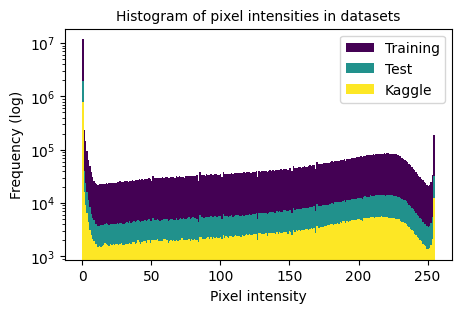

In [6]:
# Plot a histogram of pixel intensity in the full training dataset

X_flat = X.to_numpy().flatten()
X_test_flat = X_test.to_numpy().flatten()
X_kaggle_flat = X_kaggle.to_numpy().flatten()

plt.figure(figsize=(5, 3))
plt.hist(X_flat, bins=256, log=True, color=colors[0], label='Training')
plt.hist(X_kaggle_flat, bins=256, log=True, color=colors[1], label='Test')
plt.hist(X_test_flat, bins=256, log=True, color=colors[2], label='Kaggle')
plt.title(textwrap.fill('Histogram of pixel intensities in datasets', width=50), fontsize=10)
plt.xlabel('Pixel intensity', fontsize=10)
plt.ylabel('Frequency (log)', fontsize=10)
plt.legend()
plt.savefig('Pixel_intensity_plot.png', bbox_inches='tight')  # Save figure to PNG
plt.show()

### 2. Data Preprocessing

In [7]:
# Histogram of Oriented Gradients (HOG)
X_train_hog = pd.DataFrame(X_train.apply(get_hog_features, axis=1).tolist())
X_val_hog = pd.DataFrame(X_val.apply(get_hog_features, axis=1).tolist())
X_test_hog = pd.DataFrame(X_test.apply(get_hog_features, axis=1).tolist())
X_kaggle_hog = pd.DataFrame(X_kaggle.apply(get_hog_features, axis=1).tolist())

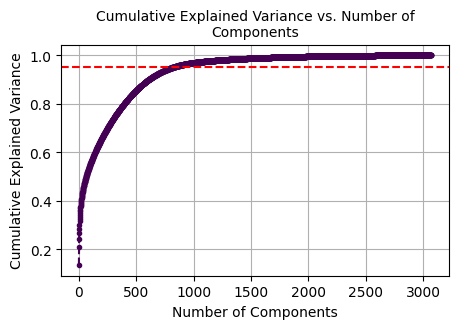

Number of components to maintain 95% variance: 820


In [8]:
## Dimensionality reduction using PCA
pca = PCA(random_state=seed)
pca.fit(X_train_hog)

# Plot the cumulative variance ratio (cvr) vs number of PCs
evr = pca.explained_variance_ratio_ 
cvr = np.cumsum(evr)

plt.figure(figsize=(5, 3))
plt.plot(cvr, marker='.', color=colors[0], linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title(textwrap.fill('Cumulative Explained Variance vs. Number of Components', width=50), fontsize=10)
plt.xlabel('Number of Components', fontsize=10)
plt.ylabel('Cumulative Explained Variance', fontsize=10)
plt.grid(True)
plt.savefig('PCA_variance_plot.png', bbox_inches='tight')  # Save figure to PNG
plt.show()

# Find the number of components that maintain 95% of the variance
n_components_95 = np.argmax(cvr >= 0.95) + 1
print(f'Number of components to maintain 95% variance: {n_components_95}')

# Return new training and test data 
pca = PCA(n_components = n_components_95)
X_train_pca, X_val_pca, X_test_pca, X_kaggle_pca = pca.fit_transform(X_train_hog), pca.transform(X_val_hog), pca.transform(X_test_hog), pca.transform(X_kaggle_hog)

In [21]:
# Sampling the training data to speed up testing
# X_train_pca = X_train_pca[:int(len(X_train_pca)*0.1)]
# Y_train = Y_train[:int(len(Y_train)*0.1)]

### 3.1. Model 1 - kNN

#### Base Implementation

In [42]:
base_knn = KNeighborsClassifier()

# Fit kNN
base_knn, fit_time = time_func(base_knn.fit, X_train_pca, Y_train)
print(f"Fit time: {fit_time:.2f} seconds")

# Predict on validation data
Y_pred_knn, pred_time = time_func(base_knn.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_knn)
print(f"kNN Accuracy on validation data: {accuracy:.3f}")

Fit time: 0.04 seconds
Prediction time: 4.09 seconds
kNN Accuracy on validation data: 0.598


#### Hyper-parameters Tuning

In [56]:
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': np.unique(np.logspace(np.log10(1), np.log10(100), num=20).astype(int)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Set up GridSearchCV
knn_cv = GridSearchCV(
    knn, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    #verbose=2
)

# Fit knn model
knn_cv, fit_time = time_func(knn_cv.fit, X_train_pca, Y_train)
total_fits = len(knn_cv.cv_results_['mean_test_score']) * knn_cv.cv
knn_train_time = fit_time/total_fits
print(f"Average fit time: {knn_train_time:.2f} seconds")

train_time = load_dict_from_json("train_time.json")
train_time["knn"] = knn_train_time
save_dict_to_json(train_time, "train_time.json")

# Print the best parameters and the best score
print(f"Best parameters: {knn_cv.best_params_}")
print(f"Best cross-validation accuracy: {knn_cv.best_score_:.3f}")

# Predict on validation data
best_knn = knn_cv.best_estimator_
Y_pred_knn, pred_time = time_func(best_knn.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_knn)
print(f"kNN Accuracy on validation data: {accuracy:.3f}")

# Save best model and results
joblib.dump(best_knn, 'best_knn.pkl')
joblib.dump(param_grid, 'knn_param_grid.pkl')
results = pd.DataFrame(knn_cv.cv_results_)
results.to_csv('knn_cv_results.csv', index=False)

Average fit time: 5.62 seconds
Best parameters: {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
Best cross-validation accuracy: 0.860
Prediction time: 4.32 seconds
kNN Accuracy on validation data: 0.868


##### Plot accuracy against hyperparameters

In [9]:
# Load from disk
best_knn = joblib.load('best_knn.pkl')
knn_results_pd = pd.read_csv('knn_cv_results.csv')
knn_param_grid = joblib.load('knn_param_grid.pkl')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


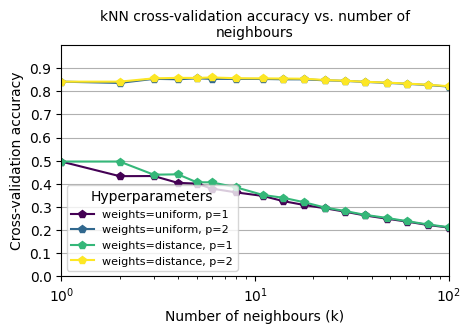

In [10]:
# Extract results
results = knn_results_pd

mean_test_scores = results['mean_test_score']
params = results['params'].apply(ast.literal_eval)

# Extract unique values for plotting
neighbors = knn_param_grid['n_neighbors']
weights = knn_param_grid['weights']
p_values = knn_param_grid['p']

# Plot results
num_lines = len(weights) * len(p_values)
plt.figure(figsize=(5, 3))
for i, weight in enumerate(weights):
    for j, p in enumerate(p_values):
        # Filter results for current weight and p value
        indices = [k for k, param in enumerate(params) if param['weights'] == weight and param['p'] == p]
        scores = [mean_test_scores[k] for k in indices]
        color = cmap((i * len(p_values) + j) / (num_lines - 1))    
        plt.plot(neighbors, scores, marker='p', linestyle='-', color=color, label=f'weights={weight}, p={p}')
plt.title(textwrap.fill('kNN cross-validation accuracy vs. number of neighbours', width=50), fontsize=10)
plt.xlabel('Number of neighbours (k)', fontsize=10)
plt.ylabel('Cross-validation accuracy', fontsize=10)
plt.xscale('log')
plt.xlim(min(neighbors),max(neighbors))
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(axis='y', which='both')

# Add legend
font_properties = FontProperties()
font_properties.set_size(10)  # Set the font size for the legend title
plt.legend(title='Hyperparameters', title_fontsize=font_properties.get_size(), prop={'size': 8})
plt.savefig('kNN_hyperparameter_plot.png', bbox_inches='tight')  # Save figure to PNG
plt.show()

### 3.2. Model 2 - SVM

#### Base Implementation

In [43]:
base_svm = SVC(random_state = seed)

# Fit SVM model
base_svm, fit_time = time_func(base_svm.fit, X_train_pca, Y_train)
print(f"Fit time: {fit_time:.2f} seconds")

# Predict on validation data
Y_pred_svm, pred_time = time_func(base_svm.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_svm)
print(f"SVM Accuracy on validation data: {accuracy:.3f}")

Fit time: 57.60 seconds
Prediction time: 34.48 seconds
SVM Accuracy on validation data: 0.675


#### Rough Hyper-parameter Tuning

In [60]:
# Finetune hyperparameters using gridsearch and k-fold cross validation
svm = SVC(kernel='rbf',
         random_state = seed)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1]   # Regularisation parameter for SVM
}

# Set up GridSearchCV
svm_cv = GridSearchCV(
    svm, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    #verbose=2
)

# Fit SVM model
svm_cv, fit_time = time_func(svm_cv.fit, X_train_pca, Y_train)
total_fits = len(svm_cv.cv_results_['mean_test_score']) * svm_cv.cv
svm_train_time = fit_time/total_fits
print(f"Average fit time: {svm_train_time:.2f} seconds")

train_time = load_dict_from_json("train_time.json")
train_time["svm"] = svm_train_time
save_dict_to_json(train_time, "train_time.json")

# Print the best parameters and the best score
print(f"Best parameters: {svm_cv.best_params_}")
print(f"Best cross-validation accuracy: {svm_cv.best_score_:.3f}")
best_svm = svm_cv.best_estimator_


# Predict on validation data
Y_pred_svm, pred_time = time_func(best_svm.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_svm)
print(f"SVM accuracy on validation data: {accuracy:.3f}")

# Save best model and results
joblib.dump(best_svm, 'best_svm_rough.pkl')
joblib.dump(param_grid, 'svm_param_grid_rough.pkl')
results = pd.DataFrame(svm_cv.cv_results_)
results.to_csv('svm_cv_results_rough.csv', index=False)

Average fit time: 172.23 seconds
Best parameters: {'C': 1, 'gamma': 0.01}
Best cross-validation accuracy: 0.886
Prediction time: 31.47 seconds
SVM accuracy on validation data: 0.888


##### Plot accuracy against hyperparameters

In [ ]:
# Load from disk
best_svm_rough = joblib.load('best_svm_rough.pkl')
svm_results_cv_rough = pd.read_csv('svm_cv_results_rough.csv') #.apply(ast.literal_eval)
svm_param_grid_rough = joblib.load('svm_param_grid_rough.pkl')

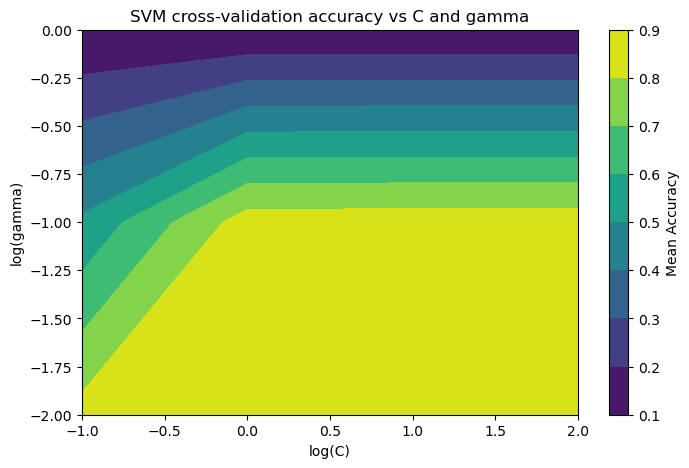

In [61]:
# Extract results
# results = svm_cv.cv_results_
results = svm_results_cv_rough
mean_scores = np.array(results['mean_test_score']).reshape(len(svm_param_grid_rough['C']), len(svm_param_grid_rough['gamma']))

# Plotting
C_values, gamma_values = np.log10(svm_param_grid_rough['C']), np.log10(svm_param_grid_rough['gamma'])
C_values, gamma_values = svm_param_grid['C'], svm_param_grid_rough['gamma']
C_grid, gamma_grid = np.meshgrid(C_values, gamma_values, indexing='ij')

plt.figure(figsize=(6, 3))
plt.contourf(C_grid, gamma_grid, mean_scores, cmap='viridis')
plt.colorbar(label='Mean Accuracy')
plt.title(textwrap.fill('SVM cross-validation accuracy vs C and gamma', width=50), fontsize=10)
plt.xlabel('C', fontsize=10)
plt.ylabel('gamma', fontsize=10)
plt.xscale('linear')
plt.yscale('linear')

plt.savefig('SVM_hyperparameter_plot.png', bbox_inches='tight')  # Save figure to PNG

plt.show()

#### Fine hyper-parameter tuning

In [62]:
svm = SVC(kernel='rbf',
         random_state = seed)

# Define the parameter grid
param_grid = {
    'C': np.arange(5, 16, 2),
    'gamma': np.arange(0.005, 0.05, 0.005)   # Regularisation parameter for SVM
}

# Set up GridSearchCV
svm_cv = GridSearchCV(
    svm, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    #verbose=2
)

# Fit SVM model
svm_cv, fit_time = time_func(svm_cv.fit, X_train_pca, Y_train)
total_fits = len(svm_cv.cv_results_['mean_test_score']) * svm_cv.cv
svm_train_time = fit_time/total_fits
print(f"Average fit time: {svm_train_time:.2f} seconds")

train_time = load_dict_from_json("train_time.json")
train_time["svm"] = svm_train_time
save_dict_to_json(train_time, "train_time.json")

# Print the best parameters and the best score
print(f"Best parameters: {svm_cv.best_params_}")
print(f"Best cross-validation accuracy: {svm_cv.best_score_:.3f}")

# Predict on validation data
best_svm = svm_cv.best_estimator_
Y_pred_svm, pred_time = time_func(best_svm.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_svm)
print(f"SVM accuracy on validation data: {accuracy:.3f}")

# Save best model and results
joblib.dump(best_svm, 'best_svm.pkl')
joblib.dump(param_grid, 'svm_param_grid.pkl')
results = pd.DataFrame(svm_cv.cv_results_)
results.to_csv('svm_cv_results.csv', index=False)

Average fit time: 59.01 seconds
Best parameters: {'C': 5, 'gamma': 0.034999999999999996}
Best cross-validation accuracy: 0.897
Prediction time: 39.25 seconds
SVM accuracy on validation data: 0.900


##### Plot accuracy against hyperparameters

In [11]:
# Load from disk
best_svm = joblib.load('best_svm.pkl')
svm_results_pd = pd.read_csv('svm_cv_results.csv') #.apply(ast.literal_eval)
svm_param_grid = joblib.load('svm_param_grid.pkl')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


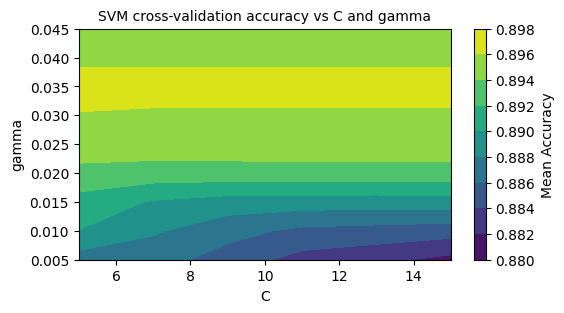

In [12]:
# Extract results
# results = svm_cv.cv_results_
results = svm_results_pd
mean_scores = np.array(results['mean_test_score']).reshape(len(svm_param_grid['C']), len(svm_param_grid['gamma']))

# Plotting
C_values, gamma_values = np.log10(svm_param_grid['C']), np.log10(svm_param_grid['gamma'])
C_values, gamma_values = svm_param_grid['C'], svm_param_grid['gamma']
C_grid, gamma_grid = np.meshgrid(C_values, gamma_values, indexing='ij')

plt.figure(figsize=(6, 3))
plt.contourf(C_grid, gamma_grid, mean_scores, cmap='viridis')
plt.colorbar(label='Mean Accuracy')
plt.title(textwrap.fill('SVM cross-validation accuracy vs C and gamma', width=50), fontsize=10)
plt.xlabel('C', fontsize=10)
plt.ylabel('gamma', fontsize=10)
plt.xscale('linear')
plt.yscale('linear')

plt.savefig('SVM_hyperparameter_plot.png', bbox_inches='tight')  # Save figure to PNG

plt.show()

### 3.3. Model 3 - Decision Tree

#### Base Implementation

In [44]:
# Decision Tree
base_dt = DecisionTreeClassifier(criterion='gini', 
                                 splitter='best',
                                 random_state=seed)

# Fit model
base_dt, fit_time = time_func(base_dt.fit, X_train_pca, Y_train)
print(f"Fit time: {fit_time:.2f} seconds")

# Predict on validation data
Y_pred_dt, pred_time = time_func(base_dt.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_dt)
print(f"Decision Tree accuracy on validation data: {accuracy:.3f}")

Fit time: 38.41 seconds
Prediction time: 0.01 seconds
Decision Tree accuracy on validation data: 0.593


#### Hyper-parameters Tuning

In [58]:
# Finetune hyperparameters using gridsearch and k-fold cross validation
dt = DecisionTreeClassifier(splitter='best',
                            random_state=seed)

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0, 0.001, 0.003, 0.005, 0.010],
}

# Set up GridSearchCV
dt_cv = GridSearchCV(
    dt, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    #verbose=2
)

# Fit Decision tree model
dt_cv, fit_time = time_func(dt_cv.fit, X_train_pca, Y_train)
total_fits = len(dt_cv.cv_results_['mean_test_score']) * dt_cv.cv
dt_train_time = fit_time/total_fits
print(f"Average fit time: {dt_train_time:.2f} seconds")

train_time = load_dict_from_json("train_time.json")
train_time["dt"] = dt_train_time
save_dict_to_json(train_time, "train_time.json")

# Print the best parameters and the best score
print(f"Best parameters: {dt_cv.best_params_}")
print(f"Best cross-validation accuracy: {dt_cv.best_score_:.3f}")

# Predict on validation data
best_dt = dt_cv.best_estimator_
Y_pred_dt, pred_time = time_func(best_dt.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_dt)
print(f"Decision tree accuracy on validation data: {accuracy:.3f}")

# Save best model and results
joblib.dump(best_dt, 'best_dt.pkl')
joblib.dump(param_grid, 'dt_param_grid.pkl')
results = pd.DataFrame(dt_cv.cv_results_)
results.to_csv('dt_cv_results.csv', index=False)

Average fit time: 10.24 seconds
Best parameters: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_features': None}
Best cross-validation accuracy: 0.777
Prediction time: 0.02 seconds
Decision tree accuracy on validation data: 0.785


##### Plot accuracy against hyperparameters

In [105]:
# Load from disk
best_dt = joblib.load('best_dt.pkl')
xgb_param_grid = joblib.load('dt_param_grid.pkl')
dt_results_pd = pd.read_csv('dt_cv_results.csv')

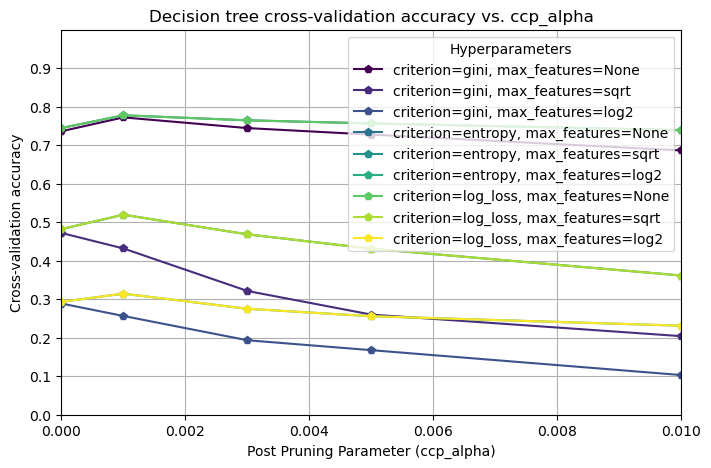

In [106]:
# Extract results
#results = dt_cv.cv_results_
results = dt_results_pd
mean_test_scores = results['mean_test_score']
params = results['params'].apply(ast.literal_eval)

# Extract unique values for plotting
dt_criterion = param_grid_dt['criterion']
dt_max_features = param_grid_dt['max_features']
dt_ccp_alpha = param_grid_dt['ccp_alpha']

# Plot results
num_lines = len(dt_criterion) * len(dt_max_features)
plt.figure(figsize=(5, 3))
for i, criterion in enumerate(dt_criterion):
    for j, max_feature in enumerate(dt_max_features):
        # Filter results for criterion and max_feature
        indices = [k for k, param in enumerate(params) if param['criterion'] == criterion and param['max_features'] == max_feature]
        scores = [mean_test_scores[k] for k in indices]
        color = cmap((i * len(dt_max_features) + j) / (num_lines - 1))    
        plt.plot(dt_ccp_alpha, scores, marker='p', linestyle='-', color=color, label=f'criterion={criterion}, max_features={max_feature}')
plt.xlabel('Post Pruning Parameter (ccp_alpha)', fontsize=10)
plt.ylabel('Cross-validation accuracy', fontsize=10)
plt.title(textwrap.fill('Decision tree cross-validation accuracy vs. ccp_alpha', width=50), fontsize=10)
#plt.xscale('log')
plt.xlim(min(dt_ccp_alpha),max(dt_ccp_alpha))
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))

# Add legend
font_properties = FontProperties()
font_properties.set_size(10)  # Set the font size for the legend title
plt.legend(title='Hyperparameters', title_fontsize=font_properties.get_size(), fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.grid(True)
plt.savefig('dt_hyperparameter_plot.png', bbox_inches='tight')  # Save figure to PNG
plt.show()

### 3.4. Model 4 - XGBoost

#### Base Implementation

In [47]:
# XGBoost
base_xgb = xgb.XGBClassifier(objective="multi:softmax",
                          tree_method="approx",
                          eval_metric="mlogloss",
                          random_state = seed)

# Fit model
base_xgb, fit_time = time_func(base_xgb.fit, X_train_pca, Y_train)
print(f"Fit time: {fit_time:.2f} seconds")

# Predict on validation data
Y_pred_xgb, pred_time = time_func(base_xgb.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_xgb)
print(f"XGBoost accuracy on validation data: {accuracy:.3f}")

Fit time: 276.93 seconds
Prediction time: 0.06 seconds
XGBoost accuracy on validation data: 0.715


#### Hyper-parameters Tuning

In [72]:
# Finetune hyperparameters using gridsearch and k-fold cross validation
start_time = time.time()

xgb_c = xgb.XGBClassifier(objective="multi:softmax",
                       tree_method="approx",
                       eval_metric="mlogloss",
                       learning_rate=0.3,
                       random_state = seed)

# Define the parameter grid
param_grid = {
    'max_depth':[3, 4, 5], 
    'n_estimators':[100, 150, 200],
    'reg_lambda': [0, 100]
}

# Set up GridSearchCV
xgb_cv = GridSearchCV(
    xgb_c, 
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy', 
    #verbose=2
)

# Fit XGBoost model
xgb_cv, fit_time = time_func(xgb_cv.fit, X_train_pca, Y_train)
total_fits = len(xgb_cv.cv_results_['mean_test_score']) * xgb_cv.cv
xgb_train_time = fit_time/total_fits
print(f"Average fit time: {xgb_train_time:.2f} seconds")

train_time = load_dict_from_json("train_time.json")
train_time["xgb"] = xgb_train_time
save_dict_to_json(train_time, "train_time.json")

# Print the best parameters and the best score
print(f"Best parameters: {xgb_cv.best_params_}")
print(f"Best cross-validation accuracy: {xgb_cv.best_score_:.3f}")

# Predict on validation data
best_xgb = xgb_cv.best_estimator_
Y_pred_xgb, pred_time = time_func(best_xgb.predict, X_val_pca)
print(f"Prediction time: {pred_time:.2f} seconds")

# Evaluate on validation data
accuracy = accuracy_score(Y_val, Y_pred_xgb)
print(f"XGBoost accuracy on validation data: {accuracy:.3f}")

# Save best model and results
joblib.dump(best_xgb, 'best_xgb.pkl')
joblib.dump(param_grid, 'xgb_param_grid.pkl')
results = pd.DataFrame(xgb_cv.cv_results_)
results.to_csv('xgb_cv_results.csv', index=False)

KeyboardInterrupt: 

##### Plot accuracy against hyperparameters

In [13]:
# Load from disk
xgb_param_grid = joblib.load('xgb_param_grid.pkl')
xgb_results_pd = pd.read_csv('xgb_cv_results.csv')

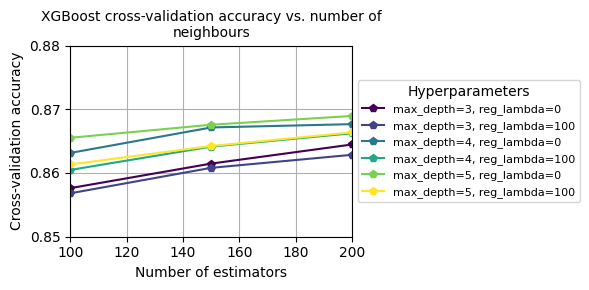

In [15]:
# Extract results
results = xgb_results_pd
mean_test_scores = results['mean_test_score']
params = results['params'].apply(ast.literal_eval)

# Extract unique values for plotting
xgb_max_depth = xgb_param_grid['max_depth']
xgb_n_estimators = xgb_param_grid['n_estimators']
xgb_lambda = xgb_param_grid['reg_lambda']

# Plot results
num_lines = len(xgb_max_depth) * len(xgb_lambda)
plt.figure(figsize=(6, 3))
for i, max_depth in enumerate(xgb_max_depth):
    for j, reg_lambda in enumerate(xgb_lambda):
        # Filter results for current depth and lambda
        indices = [k for k, param in enumerate(params) if param['max_depth'] == max_depth and param['reg_lambda'] == reg_lambda]
        scores = [mean_test_scores[k] for k in indices]
        color = cmap((i * len(xgb_lambda) + j) / (num_lines - 1))    
        plt.plot(xgb_n_estimators, scores, marker='p', linestyle='-', color=color, label=f'max_depth={max_depth}, reg_lambda={reg_lambda}')
plt.title(textwrap.fill('XGBoost cross-validation accuracy vs. number of neighbours', width=50), fontsize=10)
plt.xlabel('Number of estimators', fontsize=10)
plt.ylabel('Cross-validation accuracy', fontsize=10)
#plt.xscale('log')
plt.xlim(min(xgb_n_estimators),max(xgb_n_estimators))
plt.ylim(0.85,0.88)
plt.yticks(np.arange(0.85, 0.88, 0.01))

# Add legend
font_properties = FontProperties()
font_properties.set_size(10)  # Set the font size for the legend title
plt.legend(title='Hyperparameters', title_fontsize=font_properties.get_size(), fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.grid(True)

plt.savefig('xgb_hyperparameter_plot.png', bbox_inches='tight')  # Save figure to PNG
          
plt.show()

### 3.5. Evaluation

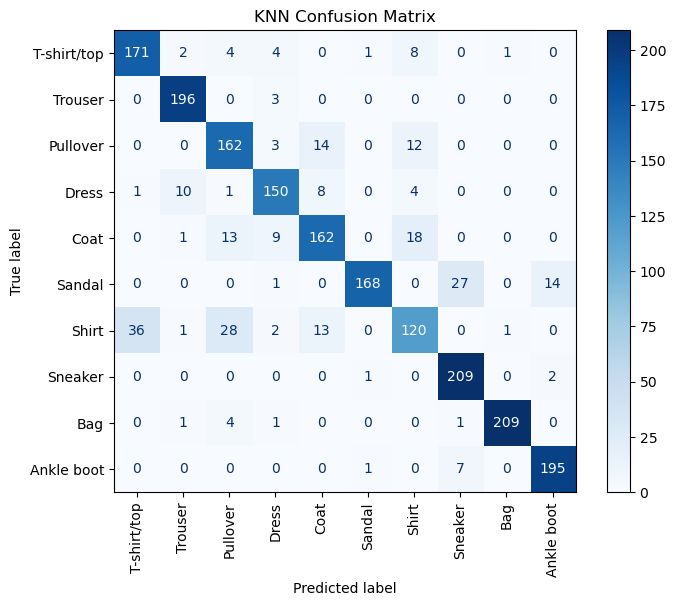

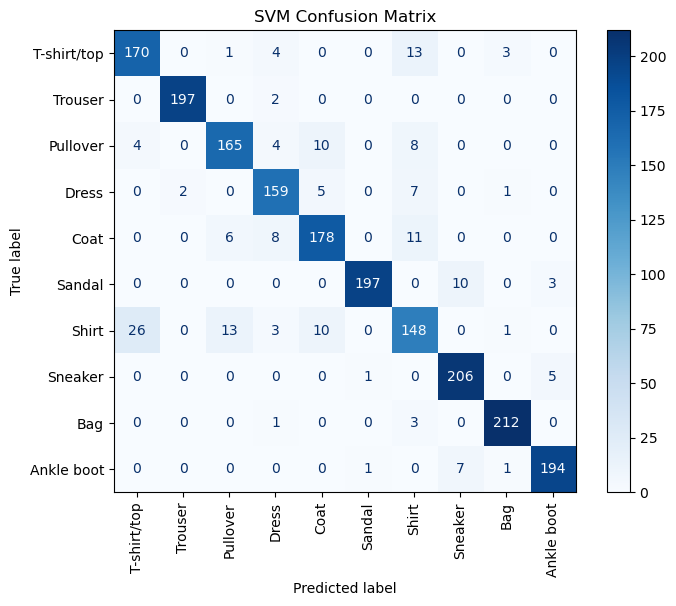

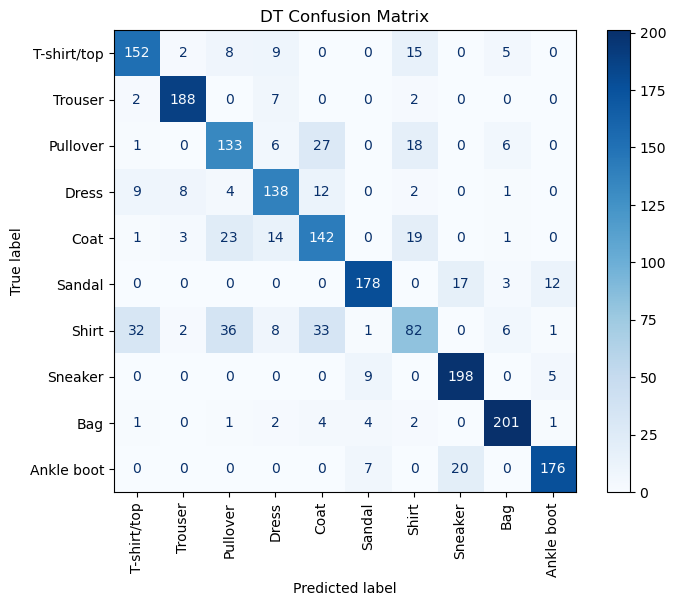

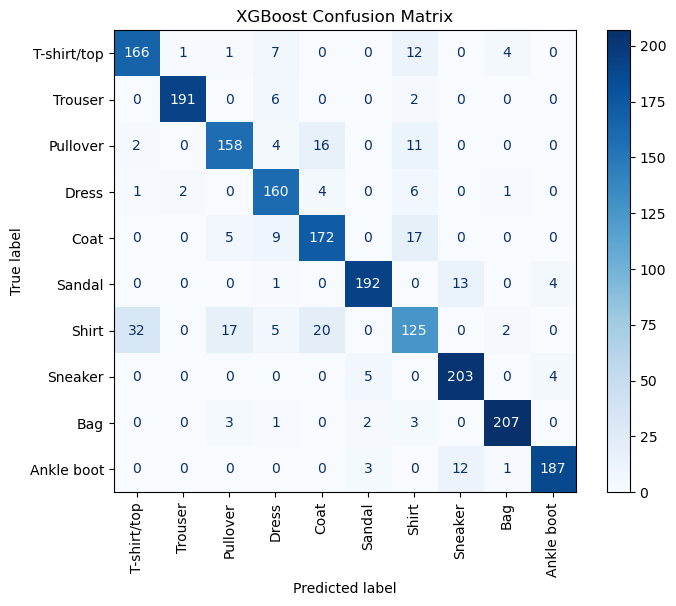

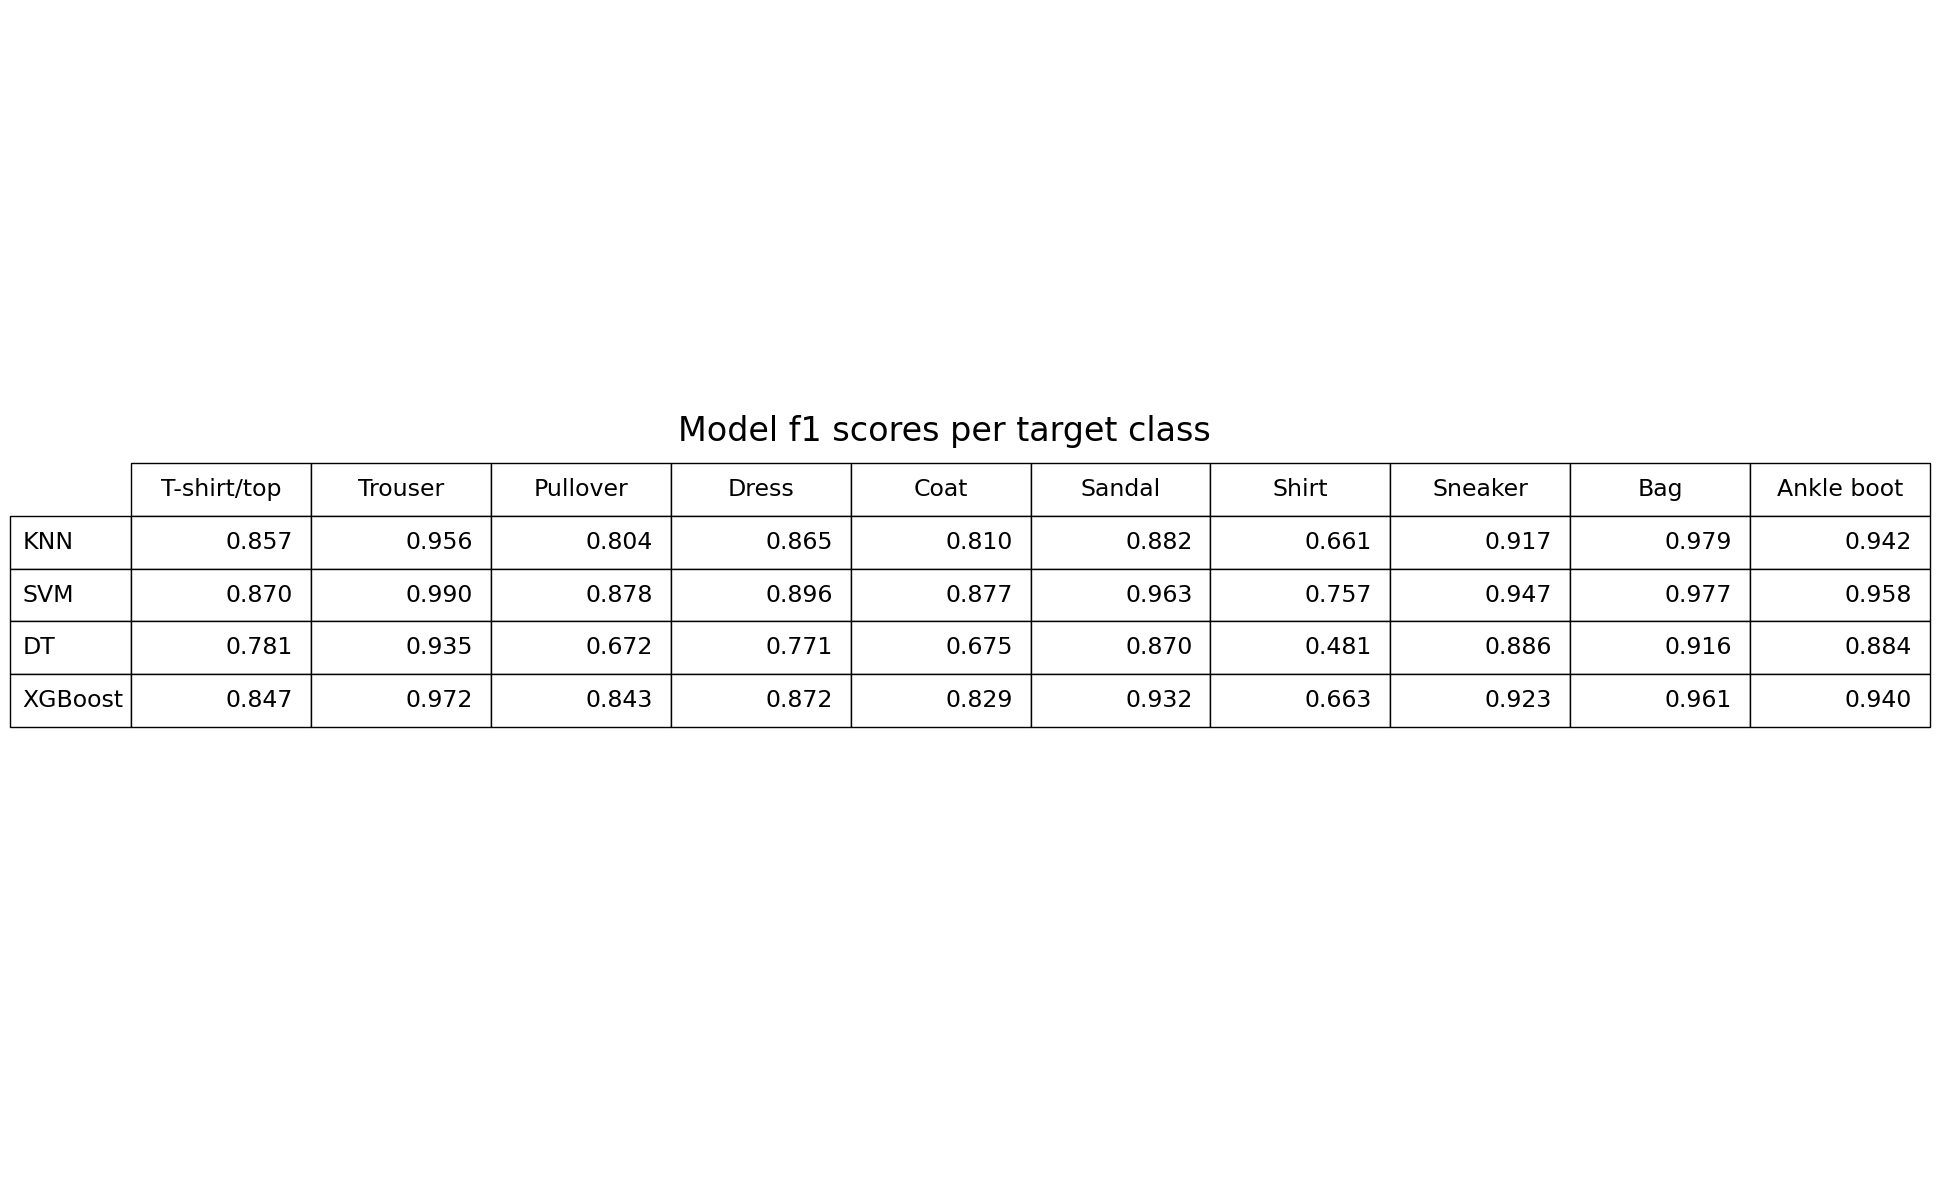

In [190]:
# Predict on test data
best_knn = joblib.load('best_knn.pkl')
best_svm = joblib.load('best_svm.pkl')
best_dt = joblib.load('best_dt.pkl')
best_xgb = joblib.load('best_xgb.pkl')
train_time = load_dict_from_json("train_time.json")

models = [best_knn, best_svm, best_dt, best_xgb]
model_names = ['KNN', 'SVM', 'DT', 'XGBoost']
train_accuracy = []
val_accuracy = []
test_accuracy = []
inference_time = []
f1_scores = []

# Rune predictions on train, val, and test data
for model, name in zip(models, model_names):

    Y_train_pred = model.predict(X_train_pca)
    train_accuracy.append(accuracy_score(Y_train, Y_train_pred))
    
    Y_val_pred = model.predict(X_val_pca)
    val_accuracy.append(accuracy_score(Y_val, Y_val_pred))

    start_time = time.time()
    Y_test_pred = model.predict(X_test_pca)
    test_accuracy.append(accuracy_score(Y_test, Y_test_pred))
    end_time = time.time()
    
    inference_time.append((end_time-start_time)/len(Y_test))

    #save f1 scores
    f1_score_list = f1_score(Y_test, Y_test_pred, average=None)
    f1_scores.append(f1_score_list)

    #display confusion matrix
    cm = confusion_matrix(Y_test, Y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    ax.set_title(name + ' Confusion Matrix')
    plt.show()
    

# Table of f1-scores
fig, ax = plt.subplots(figsize=(20, 12))
f1_scores_3f = [[f'{value:.3f}' for value in row] for row in f1_scores]
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText = f1_scores_3f, rowLabels = model_names, colLabels = label_mapping, loc = 'center')
table.set_fontsize(24)
table.scale(1, 2.5)
plt.tight_layout()
plt.suptitle('Model f1 scores per target class', fontsize=24, y=0.65)
plt.show()

### 4.1. Comparison

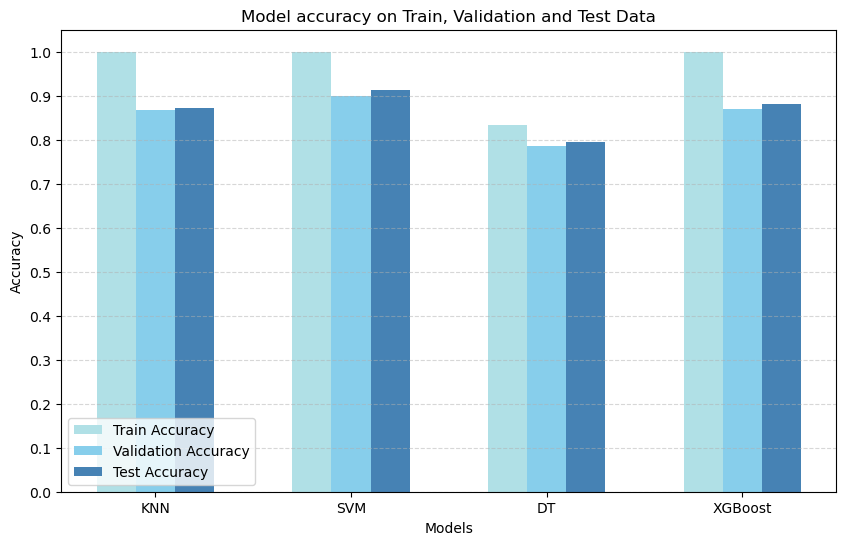

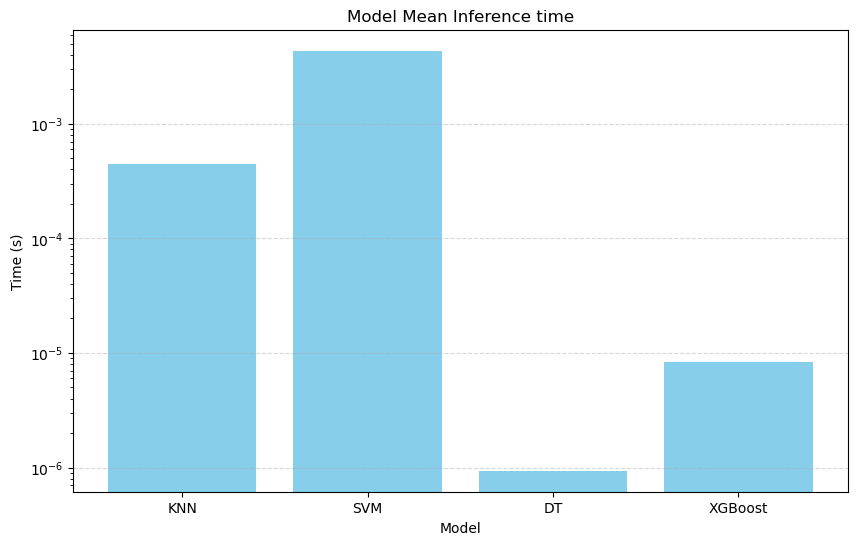

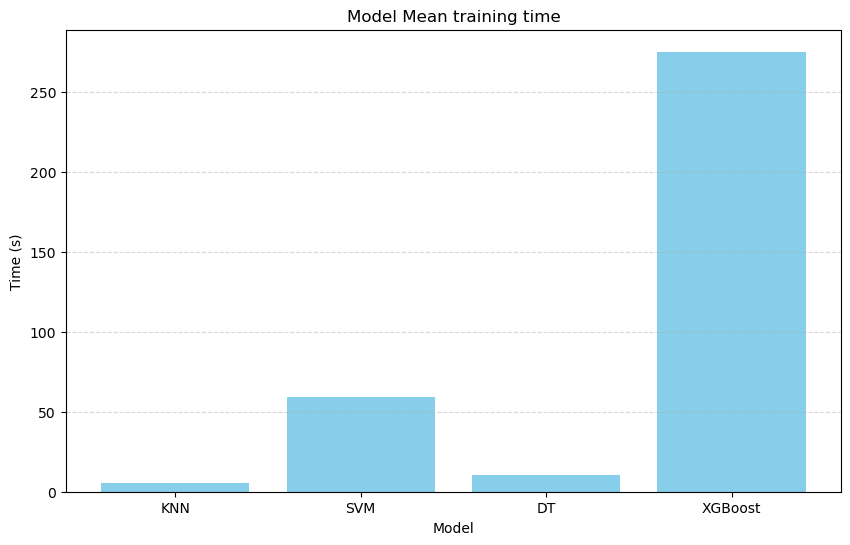

In [187]:
bar_width = 0.20
x_pos = np.arange(len(models))

# Plot Model Accuracy
plt.figure(figsize=(10, 6))
plt.bar(x_pos - bar_width, train_accuracy, width=bar_width, label='Train Accuracy', color='powderblue')
plt.bar(x_pos, val_accuracy, width=bar_width, label='Validation Accuracy', color='skyblue')
plt.bar(x_pos + bar_width, test_accuracy, width=bar_width, label='Test Accuracy', color='steelblue')
plt.title('Model accuracy on Train, Validation and Test Data')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(x_pos, model_names)
plt.yticks(np.arange(0.0, 1.05, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc = "lower left")
plt.show()

# Plot Inference Time
plt.figure(figsize=(10, 6))
plt.bar(model_names, inference_time, color='skyblue')
plt.yscale('log')
plt.title('Model Mean Inference time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Plot Training Time
train_time_list = [train_time['knn'],train_time['svm'],train_time['dt'],train_time['xgb']]
plt.figure(figsize=(10, 6))
plt.bar(model_names, train_time_list, color='skyblue')
plt.title('Model Mean training time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### 4.2. The Best Classifier

In [185]:
best_model = best_svm

### 5. Predict on Kaggle Test Data

In [186]:
output = best_model.predict(X_kaggle_pca)
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('test_output.csv', sep=",", float_format='%d',index_label="id")

### 6. Appendix

In [34]:
# K-fold Cross-validation of HOG-SVM pipeline to find optimal HOG parameters
class HOGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), image_shape=(28, 28)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.image_shape = image_shape

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        hog_features = []
        for _, row in X.iterrows():
            
            flattened_image = row.to_numpy()
            reshaped_image = flattened_image.reshape(self.image_shape)
            
            hog_feature = hog(reshaped_image, 
                              orientations=self.orientations, 
                              pixels_per_cell=self.pixels_per_cell, 
                              cells_per_block=self.cells_per_block, 
                              block_norm='L2-Hys', 
                              visualize=False)
            hog_features.append(hog_feature)
        return np.array(hog_features)

pipe = Pipeline([
    ('hog', HOGTransformer()),
    ('svc', SVC(random_state = seed))
])

param_grid = {
    'hog__orientations': [9, 12, 16],
    'hog__pixels_per_cell': [(3, 3), (4, 4), (8, 8)],
    'hog__cells_per_block': [(2, 2), (3, 3)]
}

hog_cv = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
hog_cv.fit(X_train, Y_train)

print(f"Best parameters: {hog_cv.best_params_}")
print(f"Best cross-validation accuracy: {hog_cv.best_score_:.3f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(3, 3); total time= 2.0min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(3, 3); total time= 2.1min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(3, 3); total time= 2.1min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(3, 3); total time= 2.1min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(3, 3); total time= 2.1min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(4, 4); total time= 1.3min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(4, 4); total time= 1.2min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(4, 4); total time= 1.2min
[CV] END hog__cells_per_block=(2, 2), hog__orientations=9, hog__pixels_per_cell=(4,